In [3]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
from utils import constants as cnst, u_arrays as ua
from eod import msg
from utils import u_grid, u_interpolate as u_int, constants as cnst, u_arrays, u_darrays
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import cartopy.io.shapereader as shapereader
from utils import u_statistics as u_stat
from scipy.stats import norm
import matplotlib.mlab as mlab
import pickle as pkl

coast = shapereader.natural_earth(resolution='110m',
                                  category='physical',
                                  name='coastline')

countries = shapereader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [76]:
h = 20
file = cnst.network_data + '/data/NFLICS/tables/prob_dictionary/Sahel_MCS10W10E_noOverlap_' + str(h).zfill(2) + '.p'
dic = pkl.load( open(file, "rb"))

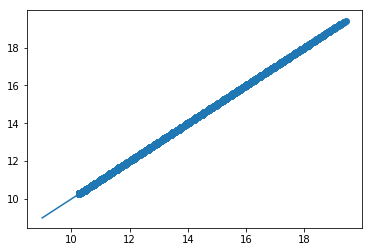

In [77]:
plt.scatter(dic['ccord'][1], dic['tcord'][1])
plt.plot(np.arange(9,19), np.arange(9,19))

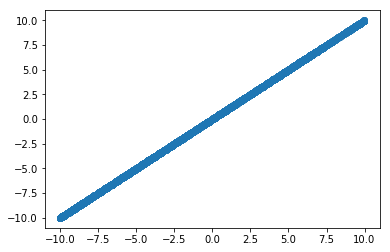

In [78]:
plt.scatter(dic['ccord'][0], dic['tcord'][0])
plt.plot(np.arange(-10,11), np.arange(-10,11))

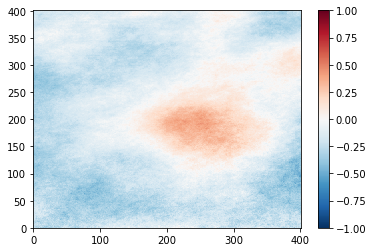

In [79]:
plt.pcolormesh((dic['akern'][0]).squeeze()/(dic['akern'][1]).squeeze(), cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

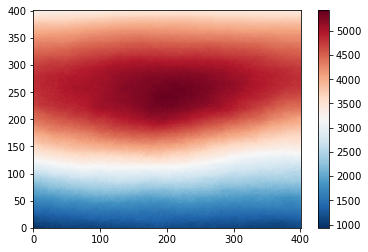

In [82]:
plt.pcolormesh((dic['akern'][1]).squeeze(), cmap='RdBu_r')
plt.colorbar()


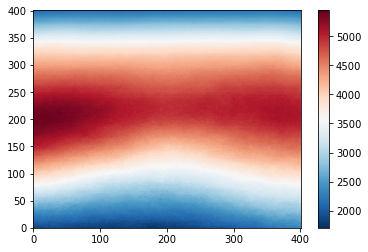

In [85]:
plt.pcolormesh((dic['rkern'][1]).squeeze(), cmap='RdBu_r')
plt.colorbar()

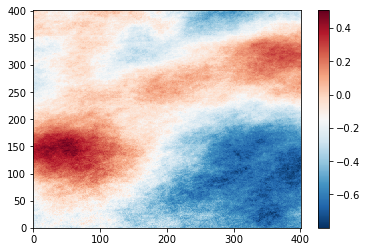

In [81]:
plt.pcolormesh((dic['rkern'][0]).squeeze()/(dic['rkern'][1]).squeeze(), cmap='RdBu_r')
plt.colorbar()

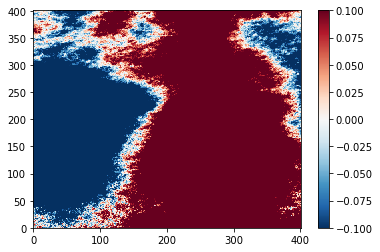

In [63]:
plt.pcolormesh((dic['akern'][0]).squeeze()/(dic['akern'][1]).squeeze()-(dic['rkern'][0]).squeeze()/(dic['rkern'][1]).squeeze(), cmap='RdBu_r', vmin=-0.1, vmax=0.1)
plt.colorbar()

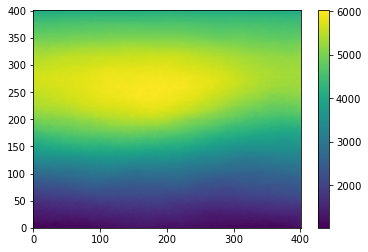

In [64]:
plt.pcolormesh((dic['akern'][1]).squeeze())
plt.colorbar()

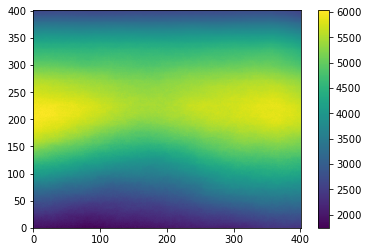

In [65]:
plt.pcolormesh((dic['rkern'][1]).squeeze())
plt.colorbar()

In [66]:
cinput = np.array(dic['amsr'][1])
rinput = np.array(dic['ramsr'][1])
point = cinput[np.isfinite(cinput)]
all = rinput[np.isfinite(rinput)]

nbpoint, pointcount, bins = u_stat.histo_frequency(point, bins=np.arange(-10,10,1))
nball, allcount, bins = u_stat.histo_frequency(all, bins=np.arange(-10, 10, 1))
print(bins)
bin_centre = bins[0:-1] + ((bins[1::] - bins[0:-1]) / 2)
bin_edge = bins[0:-1]
width = bins[1::] - bins[0:-1]

[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9]


In [67]:
# best fit of data
(mupoint, sigmapoint) = norm.fit(point)
(muall, sigmaall) = norm.fit(all)

# add a 'best fit' line
ypoint = mlab.normpdf( bins, mupoint, sigmapoint)
yall = mlab.normpdf(bins, muall, sigmaall)

# add a 'best fit' line
cypoint = norm.cdf( bins, mupoint, sigmapoint)
cyall = norm.cdf(bins, muall, sigmaall)

print('Core', norm.pdf(0,mupoint,sigmapoint))
print('Random', norm.pdf(0,muall,sigmaall))


Core 0.1252775981119411
Random 0.12292708414698764


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


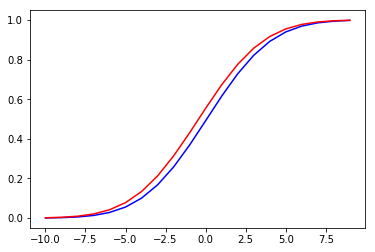

In [68]:
plt.plot(bins,cypoint, 'b')
plt.plot(bins, cyall, 'r')

56.23% of Cells occur in warmest half


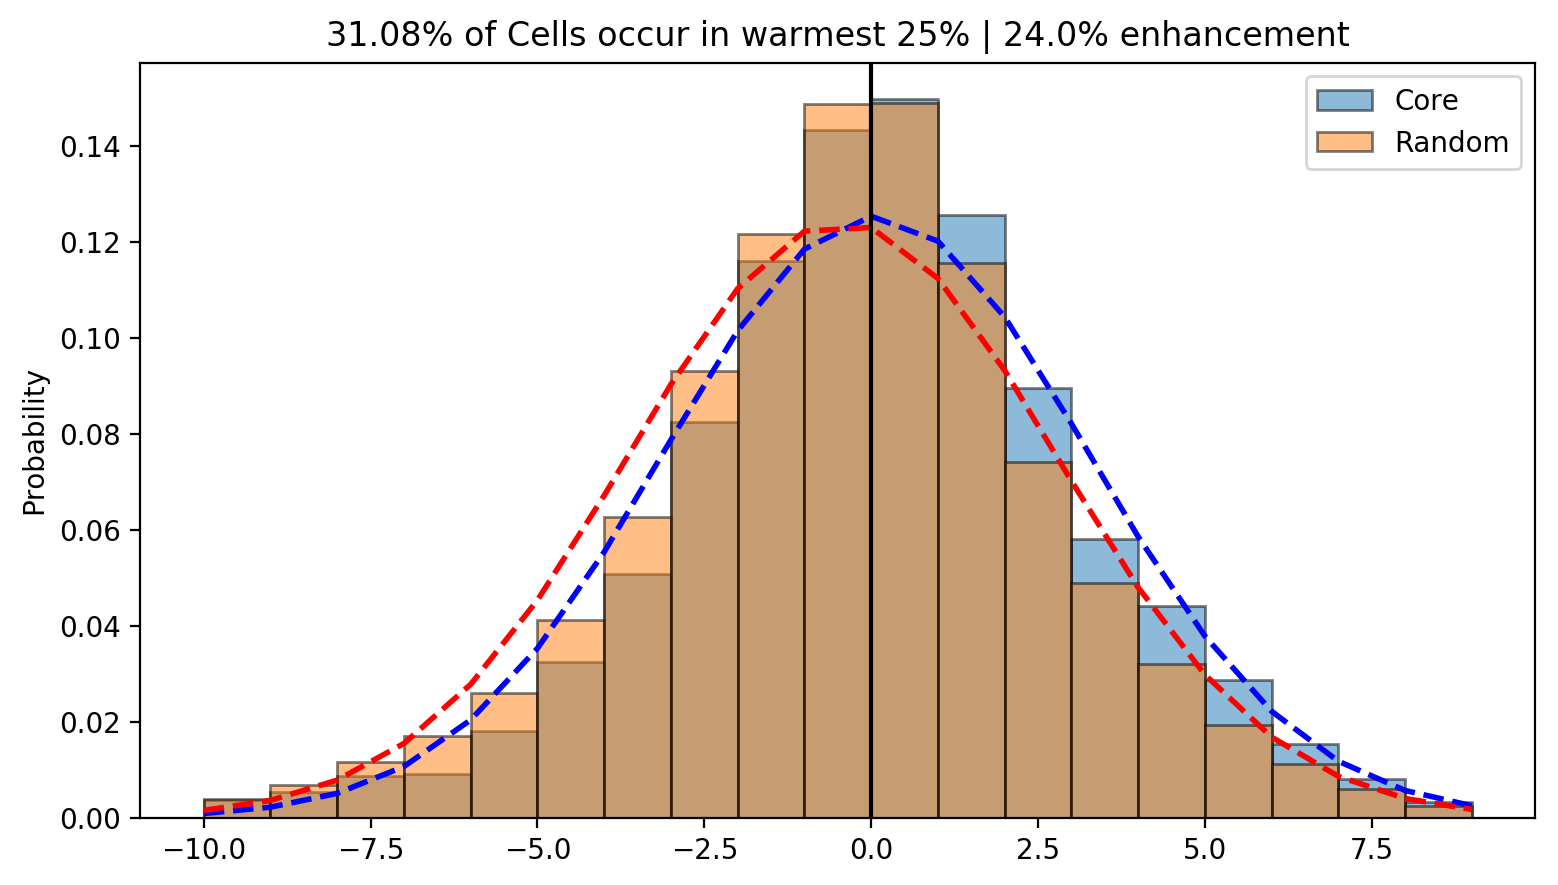

In [69]:
f = plt.figure(figsize=(9,5), dpi=200)
ax = f.add_subplot(111)

ax.bar(bin_edge, nbpoint, label='Core', edgecolor='k', alpha=0.5, align='edge', width=width)
ax.bar(bin_edge, nball, label='Random', edgecolor='k', alpha=0.5, align='edge', width=width)

plt.plot(bins, ypoint, 'b--', linewidth=2)
plt.plot(bins, yall, 'r--', linewidth=2)

plt.ylabel('Probability')
stri = (np.sum(cinput >= np.percentile(rinput, 75)) / cinput.size * 100).round(2)
enh = (stri-25)/25*100
plt.title(str(stri)+'% of Cells occur in warmest 25% | '+ str(np.round(enh))+'% enhancement')
plt.legend()

stri = (np.sum(cinput >= np.percentile(rinput, 50)) / cinput.size * 100).round(2)
print(str(stri) + '% of Cells occur in warmest half')

plt.axvline(0, color='k')
#f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/example_prob_fit.png')

In [70]:
def calc_prob(x, mu_core, mu_random, sigma_core, sigma_random):
    
    corep = norm.pdf(x,mu_core,sigma_core)
    randomp = norm.pdf(x,mu_random,sigma_random)
    
    corec = norm.cdf(x,mu_core,sigma_core)
    randomc = norm.cdf(x,mu_random,sigma_random)
    
    out_pdf = (corep - randomp)/randomp

    prob_factor = 1+out_pdf

    return out_pdf, prob_factor

In [71]:
calc_prob(1, mupoint, muall, sigmapoint, sigmaall)

(0.0692610828637902, 1.0692610828637903)

In [72]:
prob = []
factor = []
for b in bins:
    tb, fac = calc_prob(b, mupoint, muall, sigmapoint, sigmaall)
    prob.append(tb)
    factor.append(fac)

In [73]:
factor

[0.5659025093858532,
 0.6055189274666868,
 0.6466376807411445,
 0.68919397983635,
 0.7331099672836991,
 0.7782944885848623,
 0.8246429829570758,
 0.8720375027010489,
 0.9203468688763422,
 0.9694269695091128,
 1.0191212049099196,
 1.0692610828637903,
 1.119666964494381,
 1.1701489595263628,
 1.2205079675066246,
 1.2705368593302433,
 1.320021791188859,
 1.3687436408567881,
 1.4164795540945003,
 1.4630045869213575]

Text(0.5,1,'Probability factor (1-P)')

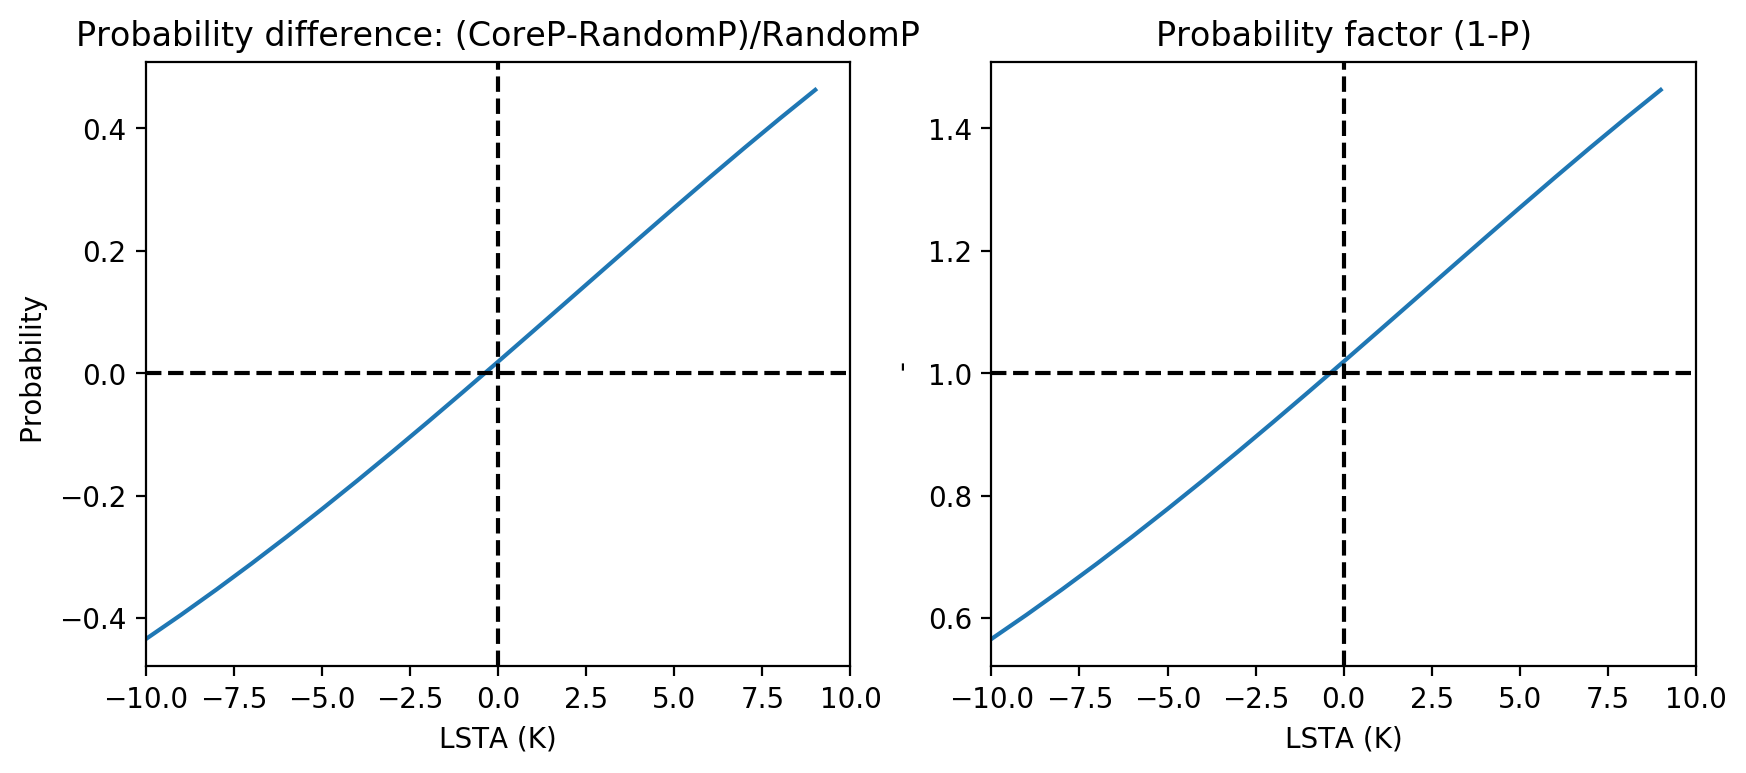

In [74]:
f = plt.figure(figsize=(10,4), dpi=200)
ax = f.add_subplot(121)
plt.plot(bins,np.array(prob))
plt.ylabel('Probability ')
plt.axhline(0,color='k', linestyle='dashed')
plt.axvline(0,color='k', linestyle='dashed')
plt.xlim(-10,10)
plt.xlabel('LSTA (K)')
plt.title('Probability difference: (CoreP-RandomP)/RandomP')

ax = f.add_subplot(122)
plt.plot(bins,np.array(factor))
plt.ylabel('-')
plt.axhline(1,color='k', linestyle='dashed')
plt.axvline(0,color='k', linestyle='dashed')
plt.xlim(-10,10)
plt.xlabel('LSTA (K)')
plt.title('Probability factor (1-P)')
#f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/p_change.png')

In [75]:
testlsta = xr.open_dataset(lpath + 'HDF5_LSASAF_ANOM_MSG_LST_MSG-Disk_200806191700.nc')

NameError: name 'lpath' is not defined

In [350]:
testlsta

<xarray.Dataset>
Dimensions:  (lat: 714, lon: 1436)
Coordinates:
  * lat      (lat) float64 0.0 0.02805 0.0561 0.08415 ... 19.92 19.94 19.97 20.0
  * lon      (lon) float64 -20.0 -19.97 -19.94 -19.92 ... 19.92 19.94 19.97 20.0
Data variables:
    lsta     (lat, lon) float64 ...
    NbSlot   (lat, lon) int16 ...

In [351]:
testlsta = testlsta.sel(lat=slice(10,20), lon=slice(-17.2,-2))

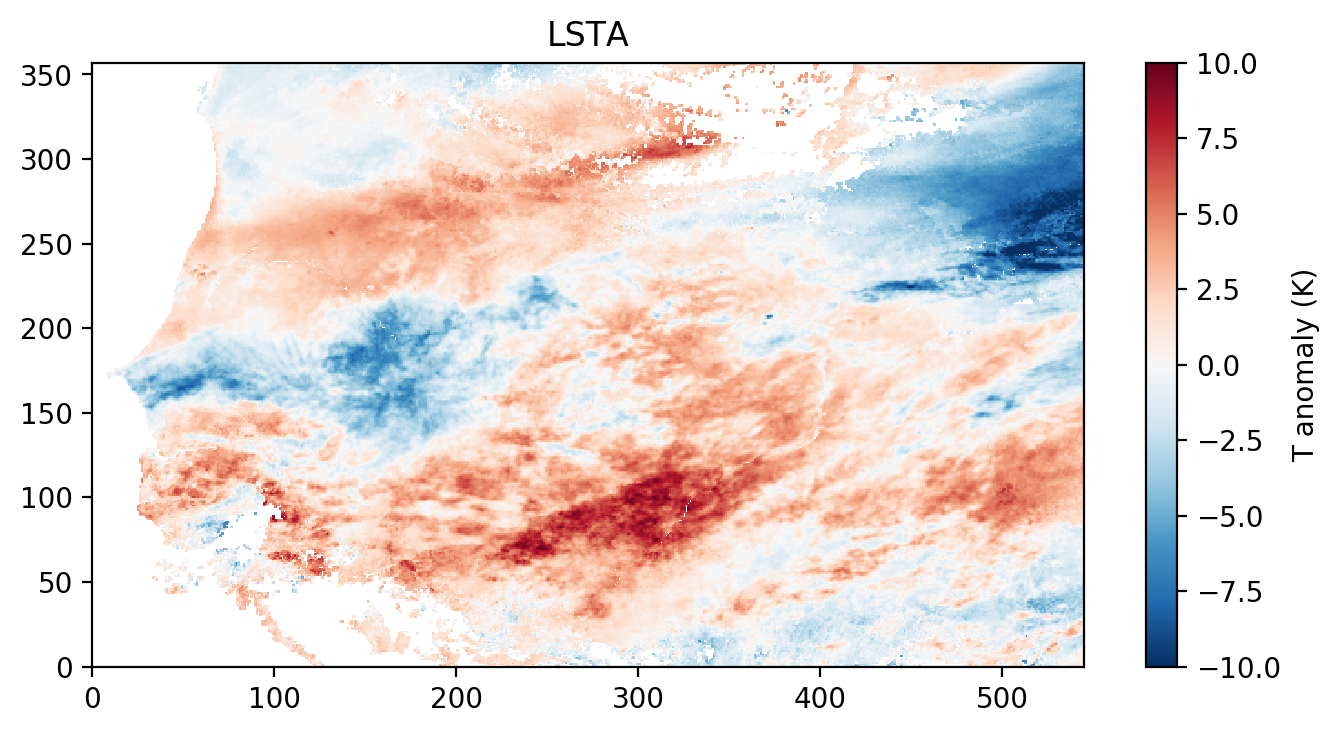

In [352]:
f=plt.figure(figsize=(8,4), dpi=200)
plt.pcolormesh(testlsta['lsta'], cmap='RdBu_r', vmin=-10, vmax=10)
plt.title('LSTA')
cbar = plt.colorbar()
cbar.set_label('T anomaly (K)')
#f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/example_day_map.png')

In [318]:
probability_map = np.zeros_like(testlsta['lsta'].values)*np.nan

In [353]:
for i in range(probability_map.shape[0]):
    for j in range(probability_map.shape[1]):
        p, fac = calc_prob(testlsta['lsta'].values[i,j], mupoint, muall, sigmapoint, sigmaall)
        probability_map[i,j] = fac
        

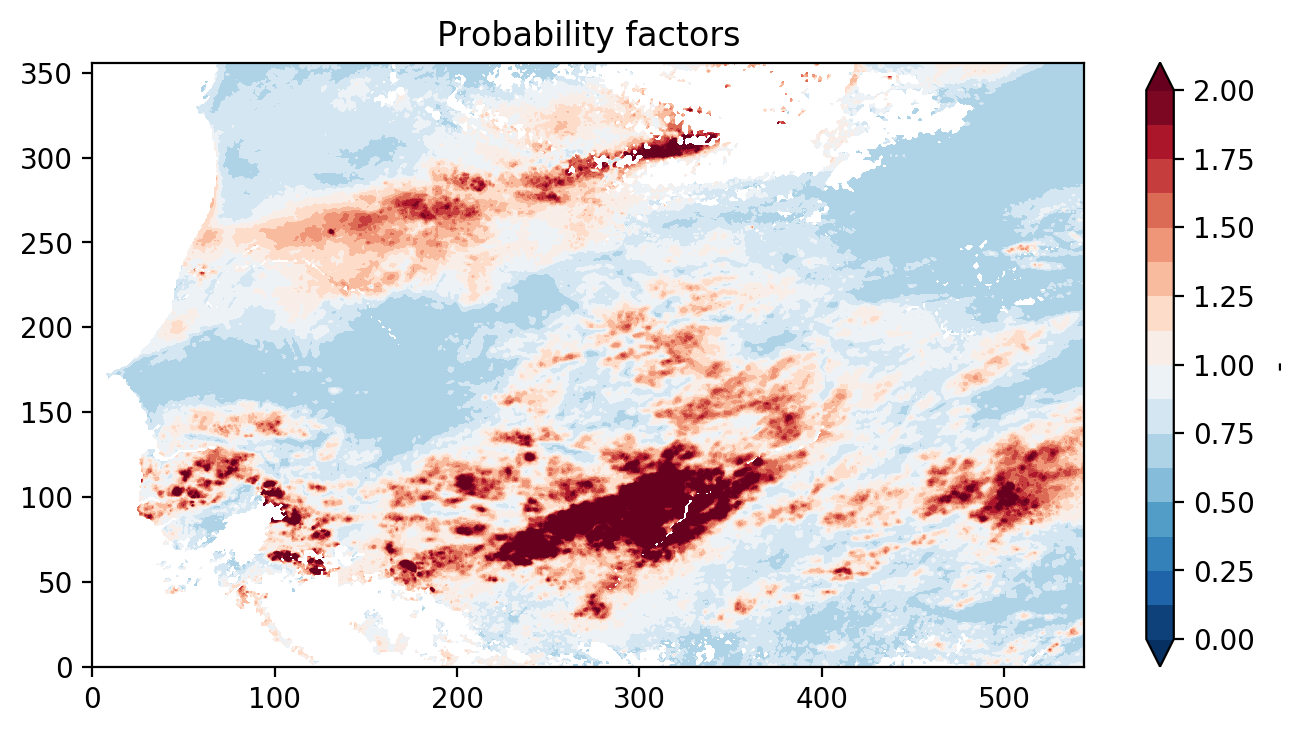

In [355]:
f=plt.figure(figsize=(8,4), dpi=200)
plt.contourf(probability_map, cmap='RdBu_r',levels=np.linspace(0,2,17), extend='both')
#plt.contour(testlsta['lsta'], cmap='RdBu_r', vmin=-10, vmax=10)
plt.title('Probability factors')
cbar = plt.colorbar()
cbar.set_label('-')
f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/example_day_map_probability.png')

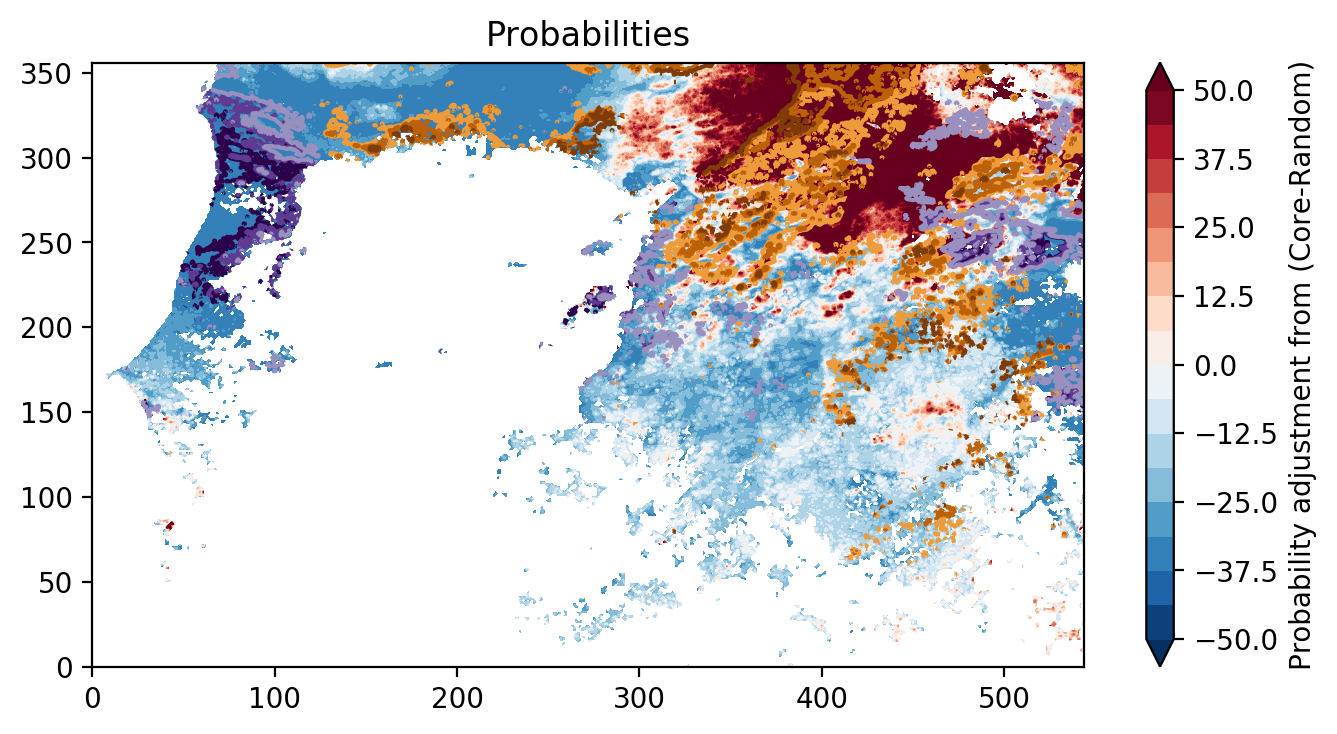

In [304]:
f=plt.figure(figsize=(8,4), dpi=200)
plt.contourf(probability_map, cmap='RdBu_r',levels=np.linspace(-50,50,17), extend='both')
#plt.contour(testlsta['lsta'], cmap='RdBu_r', vmin=-10, vmax=10)
cbar = plt.colorbar()
plt.contour(testlsta1['lsta'].values-testlsta['lsta'].values, cmap='PuOr_r', levels=[-8,-6,-4,4,6,8], extend='both')

plt.title('Probabilities')

cbar.set_label('Probability adjustment from (Core-Random)')
#f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/example_day_map_probability.png')

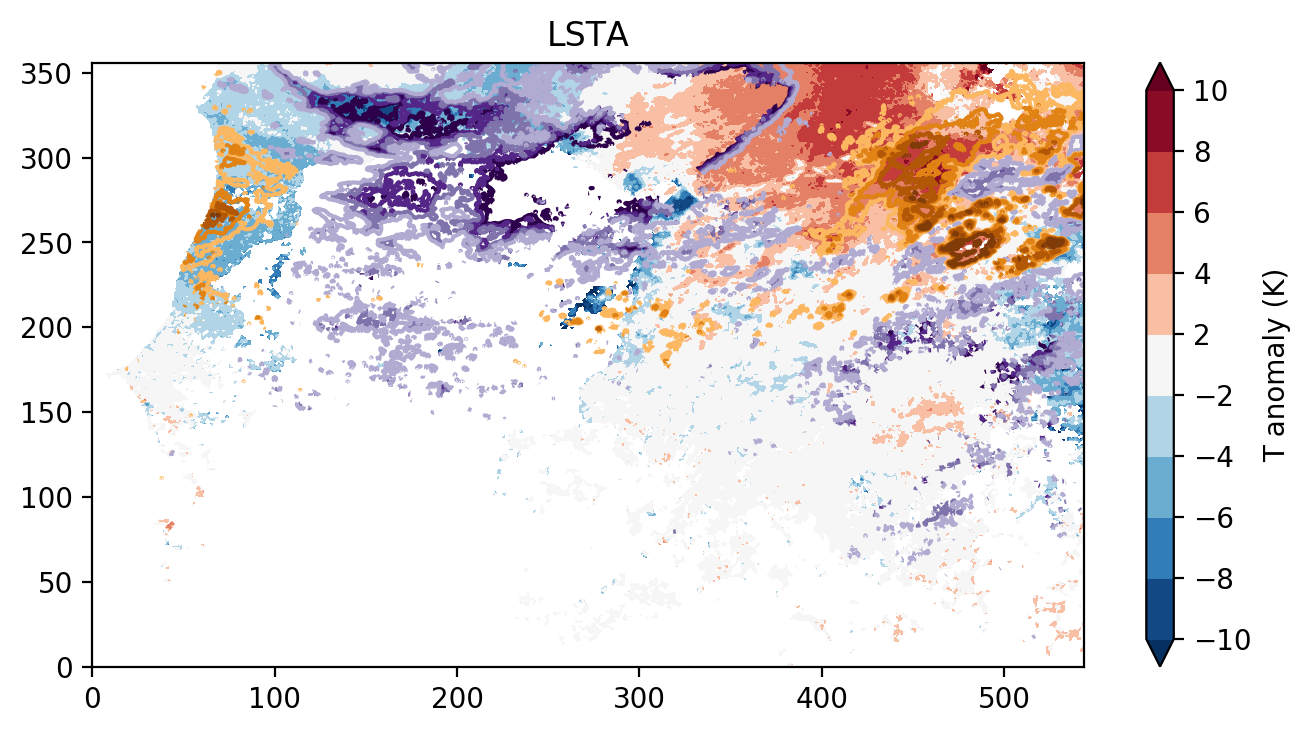

In [303]:
testlsta1 = xr.open_dataset(lpath + 'HDF5_LSASAF_ANOM_MSG_LST_MSG-Disk_201208251700.nc')
testlsta1 = testlsta1.sel(lat=slice(10,20), lon=slice(-17.2,-2))
f=plt.figure(figsize=(8,4), dpi=200)
plt.contourf(testlsta1['lsta'].values, cmap='RdBu_r', levels=[-10,-8,-6,-4,-2,2,4,6,8,10], extend='both')

plt.title('LSTA')
cbar = plt.colorbar()
plt.contour(testlsta['lsta'].values, cmap='PuOr_r', levels=[-10,-8,-6,-4,4,6,8,10])
cbar.set_label('T anomaly (K)')
#f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/example_day_map.png')

In [ ]:
def normcdf(x, mu, sigma):
    t = x-mu;
    y = 0.5*erfcc(-t/(sigma*sqrt(2.0)));
    if y>1.0:
        y = 1.0;
    return y

def normpdf(x, mu, sigma):
    u = (x-mu)/abs(sigma)
    y = (1/(sqrt(2*pi)*abs(sigma)))*exp(-u*u/2)
    return y

def normdist(x, mu, sigma, f):
    if f:
        y = normcdf(x,mu,sigma)
    else:
        y = normpdf(x,mu,sigma)
    return y